# Project Team 87

To make the outputs same for everytime we run the whole notbook, we set random state = 10 for all models.  

## Step 1: Web Scraping

In [ ]:
# Since the web scraping part takes too long to run all the data
# We seperate the scraping part and the analysis part into two files for submission

## Step 2: Data Preproccessing

In this step we import all the useful packages and do necessary Data cleaning, Including splite the text, remove no-meaning information, normaliztion and outlier removal.

In [ ]:
# import basic tools
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# tools for linear regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# tools for OLS
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the data through google drive
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive' )
data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'Steam_top.csv'))
data.head(10)

,Rank,Game Name,Current Price,Recent Comment,Release Date,Tags
0,1,Counter-Strike 2 on Steam,Free to Play,"- 77% of the 66,589 user reviews in the last 3...","Release Date:\nAug 21, 2012","FPS,Shooter,Multiplayer,Competitive,Action,Tea..."
1,2,HELLDIVERS™ 2 on Steam,$39.99,"- 87% of the 95,734 user reviews in the last 3...","Release Date:\nFeb 8, 2024","Online Co-Op,Action,Third-Person Shooter,Multi..."
2,3,Steam Deck™,0,NaN,NaN,NaN
3,4,Content Warning on Steam,$7.99,"- 92% of the 2,264 user reviews for this game ...","Release Date:\nApr 1, 2024","Online Co-Op,Horror,First-Person,Multiplayer,P..."
4,5,Save 50% on Cyberpunk 2077 on Steam,$59.99,"- 92% of the 8,403 user reviews in the last 30...","Release Date:\nDec 9, 2020","Cyberpunk,Open World,Nudity,RPG,Singleplayer,S..."
5,6,Apex Legends™ on Steam,Free to Play,"- 57% of the 14,103 user reviews in the last 3...","Release Date:\nNov 4, 2020","Free to Play,Battle Royale,Multiplayer,FPS,Sho..."
6,7,PUBG: BATTLEGROUNDS on Steam,Free to Play,"- 69% of the 21,357 user reviews in the last 3...","Release Date:\nDec 21, 2017","Survival,Shooter,Battle Royale,Multiplayer,FPS..."
7,8,Save 75% on The Elder Scrolls® Online on Steam,$19.99,- 79% of the 940 user reviews in the last 30 d...,"Release Date:\nApr 4, 2014","RPG,MMORPG,Open World,Adventure,Fantasy,Explor..."
8,9,Baldur's Gate 3 on Steam,$59.99,"- 95% of the 14,551 user reviews in the last 3...","Release Date:\nAug 3, 2023","RPG,Choices Matter,Character Customization,Sto..."
9,10,Dragon's Dogma 2 on Steam,$69.99,"- 59% of the 53,731 user reviews for this game...","Release Date:\nMar 21, 2024","RPG,Open World,Action RPG,Action,Adventure,Sin..."


### Getting useful data from the row dataframe

In [ ]:
def extract_data(text):
    """
    Extracts percentage and total number of reviews from text using regular expressions

    Parameters:
    - text (str): Input text containing percentage and total number of reviews

    Returns:
    - pct_positive (int): Percentage of positive reviews extracted from text
    - total_reviews (int): Total number of reviews extracted from text
    """
    # Using regex to find the percentage and the total number of reviews
    pct_match = re.search(r'(\d+)%', text)
    total_match = re.search(r'of the ([\d,]+)', text)

    # Extracting the matched groups and removing commas from numbers
    pct_positive = int(pct_match.group(1)) if pct_match else None
    total_reviews = int(total_match.group(1).replace(',', '')) if total_match else None

    return pct_positive, total_reviews

def count_elements(nested_list):
    """
    Counts the occurrences of each element

    Parameters:
    - nested_list (list of lists): Input list containing elements to be counted

    Returns:
    - element_counts (dict): Dictionary containing the count of each element.
    """
    flattened_list = [element for sublist in nested_list for element in sublist]

    # Dictionary to store the count of each element
    element_counts = {}

    # Iterate through the flattened list and count each element
    for element in flattened_list:
        if element in element_counts:
            element_counts[element] += 1
        else:
            element_counts[element] = 1

    return element_counts

In [ ]:
cleaned_data = data.dropna()

In [ ]:
# delete the text in release date column
cleaned_data['Release Date'] = cleaned_data['Release Date'].str.replace('Release Date:\n', '')

# delete the '$' mark, fill in N/A as zero, and change column name
cleaned_data['Current Price'] = cleaned_data['Current Price'].str.replace('$', '')
cleaned_data['Current Price'] = pd.to_numeric(cleaned_data['Current Price'], errors='coerce').fillna(0)
cleaned_data = cleaned_data.rename(columns={'Current Price': 'Current Price $'})

# cleaned the strange symbols in game names and delete the words 'on Steam' after game names
cleaned_data['Game Name'] = cleaned_data['Game Name'].str.replace(' on Steam', '')
cleaned_data['Game Name'] = cleaned_data['Game Name'].apply(lambda x: re.sub(r'^Save \d+% on ', '', x))

# apply function 'extra_data' to form new columns of total reviews and positive percentage
cleaned_data[['pct_positive_views', 'total_reviews']] =  cleaned_data['Recent Comment'].apply(lambda x: pd.Series(extract_data(x)))

# separate the tags and create a new column 'Tag_num' to store the length of tags for each game
cleaned_data['Tag_num'] = cleaned_data['Tags'].str.split(',').apply(len)
# clean the '+' sign at the end of every tag row
cleaned_data['Tags'] = cleaned_data['Tags'].str.replace('+', '', regex=False)

# Convert the 'Date' column to datetime format, coercing errors to NaT
cleaned_data['Release Date'] = pd.to_datetime(cleaned_data['Release Date'], errors='coerce')

# Calculate the number of days from the dates in the 'Date' column to a specific date (April 5, 2024)
specific_date = pd.Timestamp('2024-04-05')
cleaned_data['Days_now'] = (specific_date - cleaned_data['Release Date']).dt.days

# Display the DataFrame to verify the changes
cleaned_data[['Release Date', 'Days_now']]

cleaned_data.head()

<ipython-input-54-46e7068980a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Release Date'] = cleaned_data['Release Date'].str.replace('Release Date:\n', '')
<ipython-input-54-46e7068980a1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Current Price'] = cleaned_data['Current Price'].str.replace('$', '')
<ipython-input-54-46e7068980a1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,Rank,Game Name,Current Price $,Recent Comment,Release Date,Tags,pct_positive_views,total_reviews,Tag_num,Days_now
0,1,Counter-Strike 2,0.00,"- 77% of the 66,589 user reviews in the last 3...",2012-08-21,"FPS,Shooter,Multiplayer,Competitive,Action,Tea...",77.0,66589.0,20,4245.0
1,2,HELLDIVERS™ 2,39.99,"- 87% of the 95,734 user reviews in the last 3...",2024-02-08,"Online Co-Op,Action,Third-Person Shooter,Multi...",87.0,95734.0,20,57.0
3,4,Content Warning,7.99,"- 92% of the 2,264 user reviews for this game ...",2024-04-01,"Online Co-Op,Horror,First-Person,Multiplayer,P...",92.0,2264.0,20,4.0
4,5,Cyberpunk 2077,59.99,"- 92% of the 8,403 user reviews in the last 30...",2020-12-09,"Cyberpunk,Open World,Nudity,RPG,Singleplayer,S...",92.0,8403.0,20,1213.0
5,6,Apex Legends™,0.00,"- 57% of the 14,103 user reviews in the last 3...",2020-11-04,"Free to Play,Battle Royale,Multiplayer,FPS,Sho...",57.0,14103.0,20,1248.0


In [ ]:
def plot_histogram(list, title, xlabel, ylabel):
    """
    Plots a histogram of the given data list

    Parameters:
    - data_list (list): Input list of data values
    - title (str): Title of the histogram plot
    - xlabel (str): Label for the x-axis
    - ylabel (str): Label for the y-axis
    """
    plt.hist(list, bins=30, edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


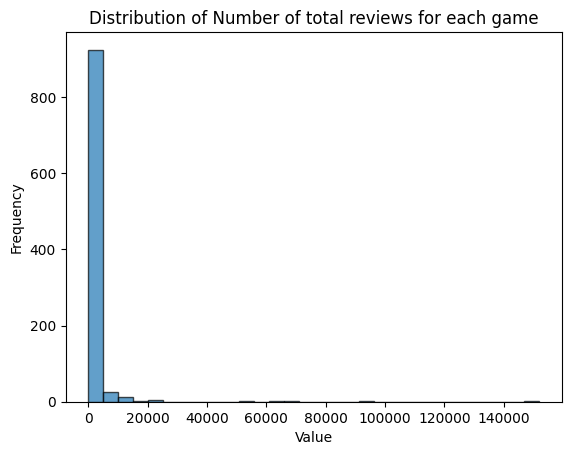

In [ ]:
# plot a histogram for total reviews
plot_histogram(cleaned_data['total_reviews'],'Distribution of Number of total reviews for each game','Value','Frequency')

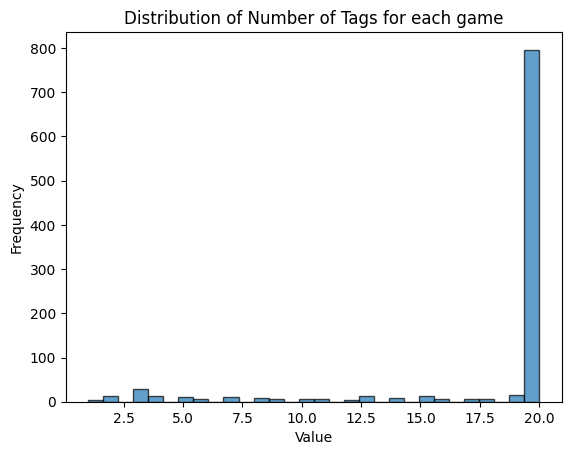

In [ ]:
# plot a histogram for the new tag length column
plot_histogram(cleaned_data['Tag_num'],'Distribution of Number of Tags for each game','Value','Frequency')

It is obviously that the difference between each game's tag numbers is too small, and most game has 20 tags. So we decide to creat a popular tag list and use the popular tag number that each game has to instead the total tag number.

In [ ]:
# utilize 'count_elements' function to count elements
element_counts = count_elements(cleaned_data['Tags'].str.split(','))

# Sort the dictionary items by count in ascending order
sorted_elements = sorted(element_counts.items(), key=lambda x: x[1], reverse = True)

In [ ]:
# initialize an empty list to store popular tags
pop_tags = []

# record the length for all tags and filter out the 10% most popular ones
total_elements = len(sorted_elements)
top_10pct_elements = sorted_elements[:total_elements // 10]

# Now, 'top_10pct_elements' contains only the top 10% of the elements from 'sorted_elements'
for element, count in top_10pct_elements:
    pop_tags.append(element)

In [ ]:
# initialize an empty list to store popular tags number for each game
cleaned_data['num_pop_tag'] = 0

for index, row in cleaned_data.iterrows():
    # Split the tags in the current row
    current_tags = row['Tags'].split(',')
    # Count how many tags are in the pop_tags list
    count_pop_tags = sum(tag in pop_tags for tag in current_tags)
    # Assign this count to the new column for the current row
    cleaned_data.at[index, 'num_pop_tag'] = count_pop_tags

cleaned_data[['Game Name','Tags', 'num_pop_tag']].head()

,Game Name,Tags,num_pop_tag
0,Counter-Strike 2,"FPS,Shooter,Multiplayer,Competitive,Action,Tea...",12
1,HELLDIVERS™ 2,"Online Co-Op,Action,Third-Person Shooter,Multi...",13
3,Content Warning,"Online Co-Op,Horror,First-Person,Multiplayer,P...",10
4,Cyberpunk 2077,"Cyberpunk,Open World,Nudity,RPG,Singleplayer,S...",14
5,Apex Legends™,"Free to Play,Battle Royale,Multiplayer,FPS,Sho...",13


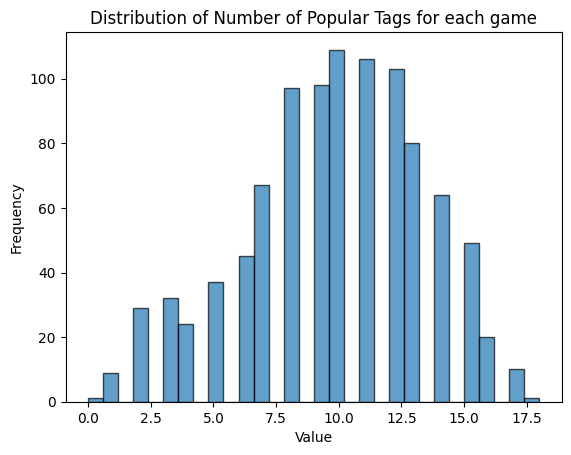

In [ ]:
# plot a histogram for number of popular tags
plot_histogram(cleaned_data['num_pop_tag'],'Distribution of Number of Popular Tags for each game','Value','Frequency')

Using a value such as 'Date' directly for training a predictive model can be challenging. Therefore, we've opted to convert the 'Date' data into a numerical format that represents "the number of days from the game's release date to the present." This numerical data is more conducive for model training purposes. The data was collected on 2024/04/05, which we are considering as the 'current' date for this transformation.

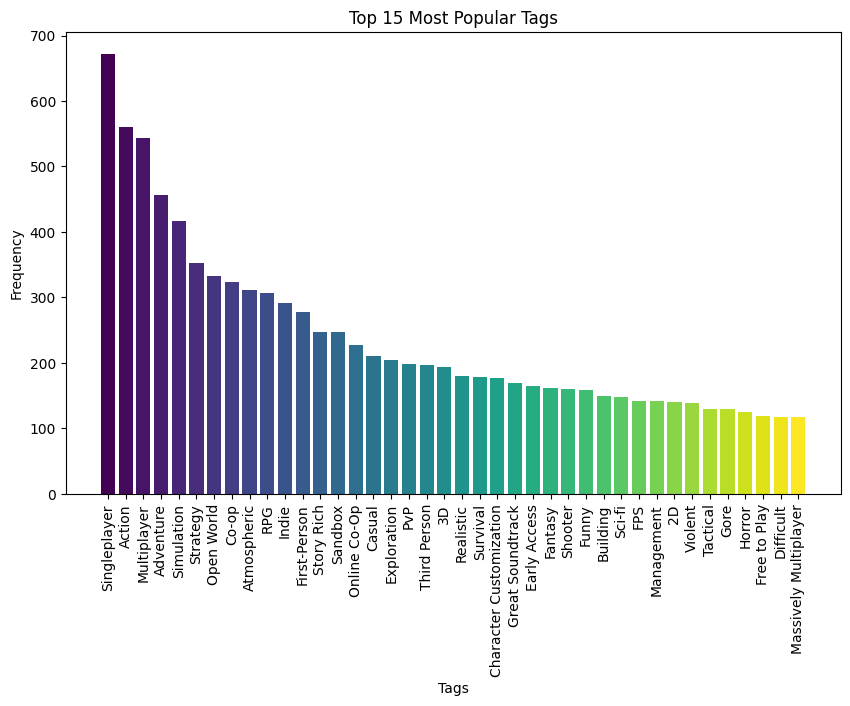

In [ ]:
# extract top 10% popular tags
top_tags = sorted_elements[:40]

# Extract tags and their counts
tags = [tag[0] for tag in top_tags]
counts = [tag[1] for tag in top_tags]

# plot a bar chart for top 15 most popular tags with most games included
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(tags)))
plt.bar(tags, counts,color=colors)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 15 Most Popular Tags')
plt.xticks(rotation=90)
plt.show()

In [ ]:
cleaned_data.head()

,Rank,Game Name,Current Price $,Recent Comment,Release Date,Tags,pct_positive_views,total_reviews,Tag_num,Days_now,num_pop_tag
0,1,Counter-Strike 2,0.00,"- 77% of the 66,589 user reviews in the last 3...",2012-08-21,"FPS,Shooter,Multiplayer,Competitive,Action,Tea...",77.0,66589.0,20,4245.0,12
1,2,HELLDIVERS™ 2,39.99,"- 87% of the 95,734 user reviews in the last 3...",2024-02-08,"Online Co-Op,Action,Third-Person Shooter,Multi...",87.0,95734.0,20,57.0,13
3,4,Content Warning,7.99,"- 92% of the 2,264 user reviews for this game ...",2024-04-01,"Online Co-Op,Horror,First-Person,Multiplayer,P...",92.0,2264.0,20,4.0,10
4,5,Cyberpunk 2077,59.99,"- 92% of the 8,403 user reviews in the last 30...",2020-12-09,"Cyberpunk,Open World,Nudity,RPG,Singleplayer,S...",92.0,8403.0,20,1213.0,14
5,6,Apex Legends™,0.00,"- 57% of the 14,103 user reviews in the last 3...",2020-11-04,"Free to Play,Battle Royale,Multiplayer,FPS,Sho...",57.0,14103.0,20,1248.0,13


In [ ]:
features = ['Current Price $', 'Days_now', 'pct_positive_views', 'num_pop_tag']
columns_to_scale = features + ['total_reviews']

In [ ]:
def subplot(columns,title):
    """
    Creates subplots for each column in the DataFrame and plots histograms of the column values

    Parameters:
    - columns (list): List of column names to be plotted
    - title (str): Title for the entire subplot
    """
    # Creating subplots
    fig, axs = plt.subplots(1, len(columns), figsize=(len(columns) * 5, 5))

    # Looping through each feature and plotting its histogram in a subplot
    for i, feature in enumerate(columns):
        axs[i].hist(cleaned_data[feature], bins=30, color='lightgreen', edgecolor='black')
        axs[i].set_title(feature)
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')

    plt.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

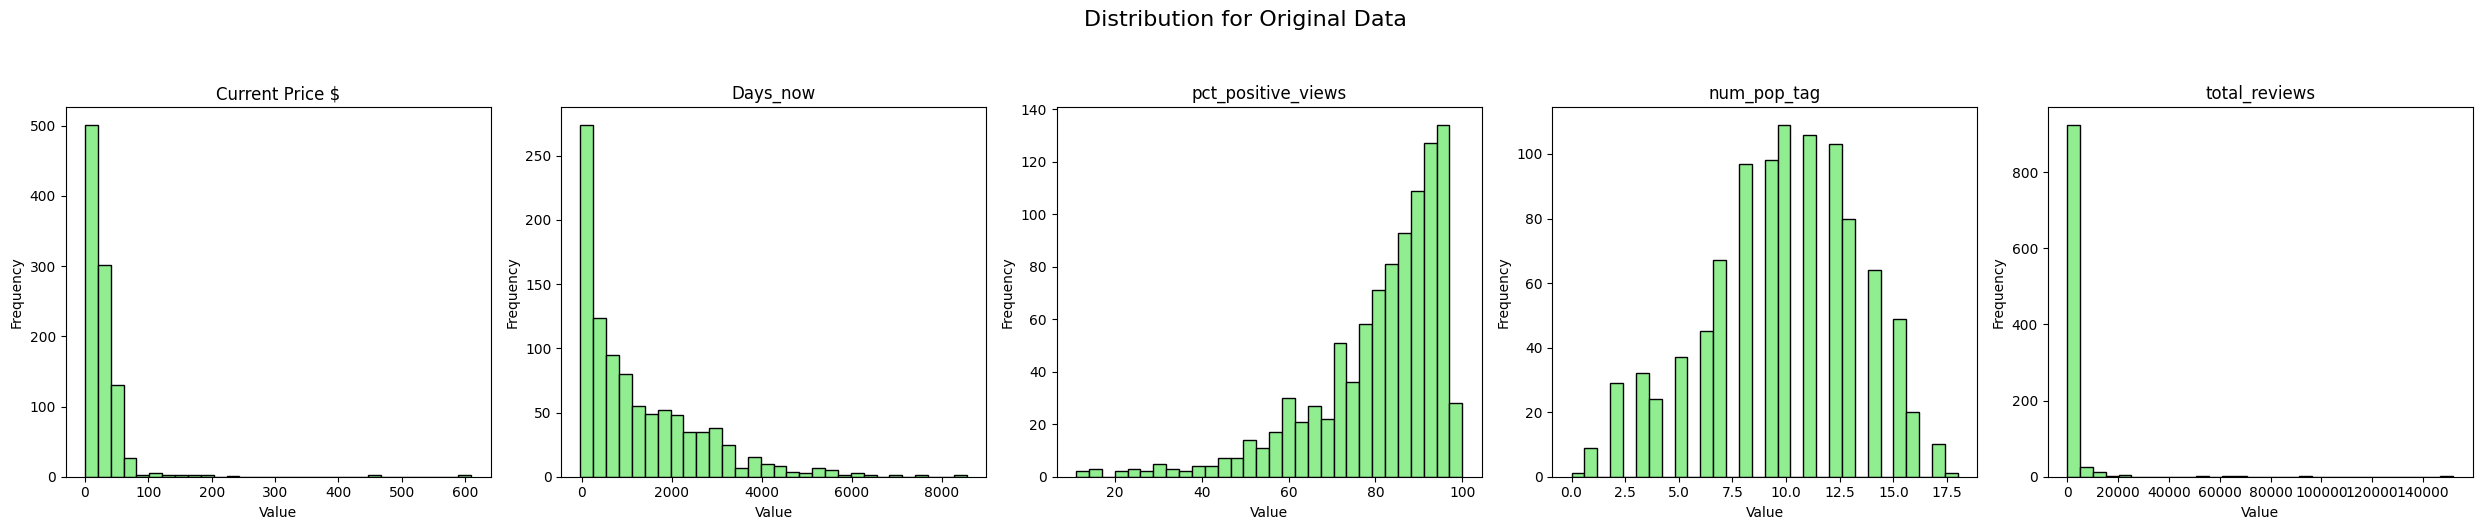

In [ ]:
# create subplot for orginal data
subplot(columns_to_scale, 'Distribution for Original Data')

We've noticed significant differences in the scale of our features. For instance, the current price varies from 0 to 200, while the 'Days_now' spans from 0 to 6000. Such disparities can result in inaccuracies in our predictions. Additionally, our dataset contains numerous outliers, which could further compromise the model's performance. To address these issues, we'll first eliminate the outliers and then rescale the data using the Z-score method.

### Rescaling the data using the Z-score normalization method.

In [ ]:
cleaned_data['original_total_reviews'] = cleaned_data['total_reviews'].copy()

def remove_outliers(df, features, threshold):
    """
    Removes outliers from the specified features in the DataFrame

    Parameters:
    - df (DataFrame): Input DataFrame containing the data
    - features (list): List of feature columns to remove outliers from
    - threshold (float): Threshold value for outlier detection (in terms of standard deviations from the mean)

    Returns:
    - df (DataFrame): DataFrame with outliers removed from specified features.
    """
    for feature in features:
        # Calculate the threshold values
        lower_bound = df[feature].mean() - threshold * df[feature].std()
        upper_bound = df[feature].mean() + threshold * df[feature].std()

        # Remove outliers
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

    return df

# Specify the threshold for outlier removal
threshold = 3

# Remove outliers from the DataFrame
cleaned_data = remove_outliers(cleaned_data, columns_to_scale, threshold)

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Apply Z-Score normalization to the selected features
cleaned_data[columns_to_scale] = scaler.fit_transform(cleaned_data[columns_to_scale])

# Check the normalized data
cleaned_data[features].head()

,Current Price $,Days_now,pct_positive_views,num_pop_tag
3,-0.904533,-1.025982,0.731193,0.099363
4,1.542506,0.010226,0.731193,1.226704
5,-1.280530,0.040224,-1.888414,0.944869
6,-1.280530,0.939299,-0.990263,1.508539
7,-0.339832,2.102355,-0.241804,0.944869


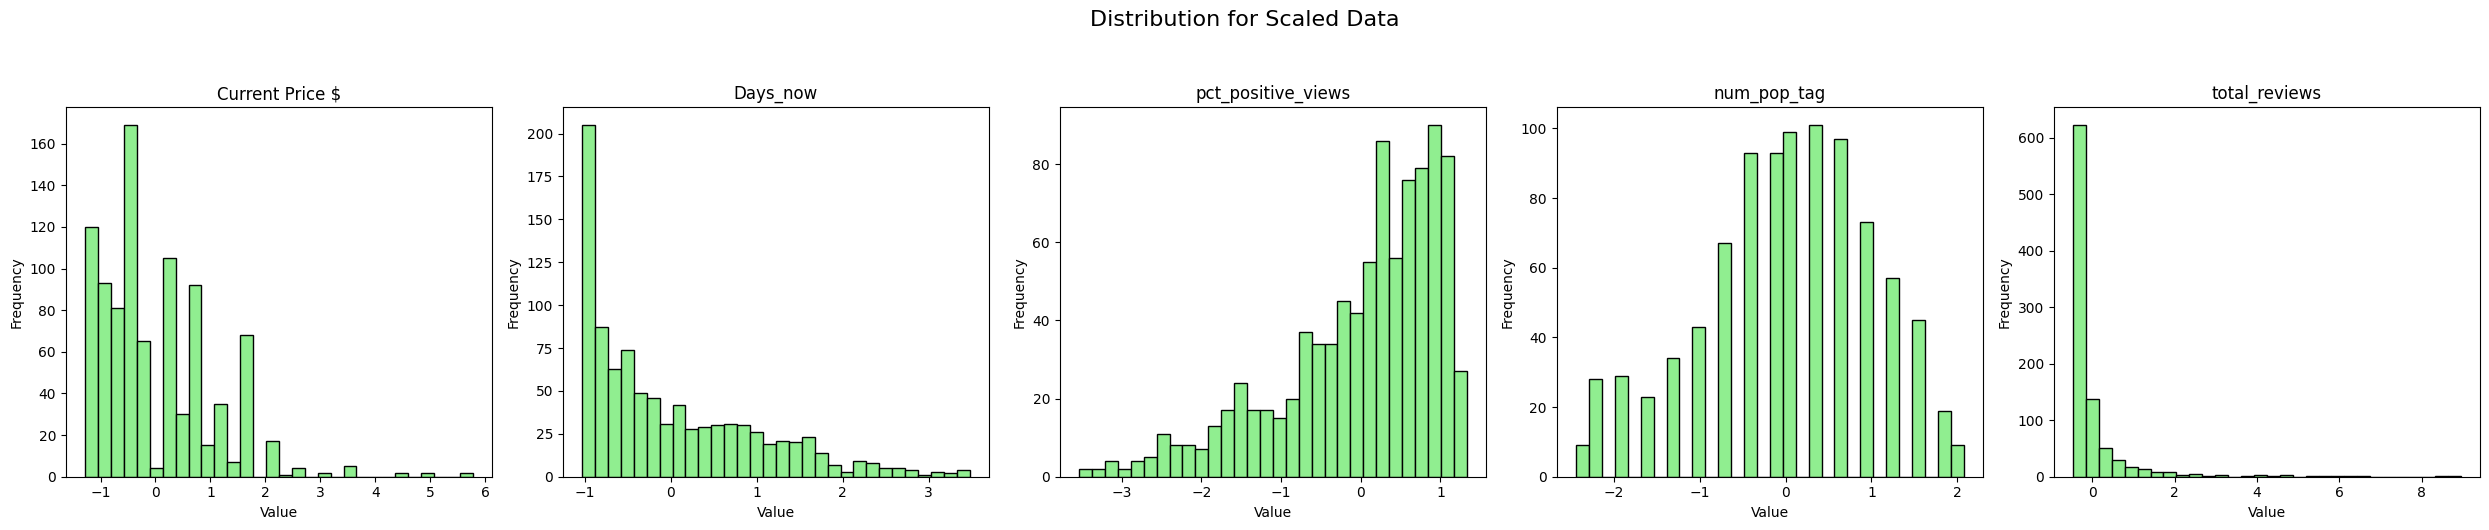

In [ ]:
# create subplot for scaled data
subplot(columns_to_scale, 'Distribution for Scaled Data')

Now we want to see if there is a relationship between our independent variables and the dependent variable

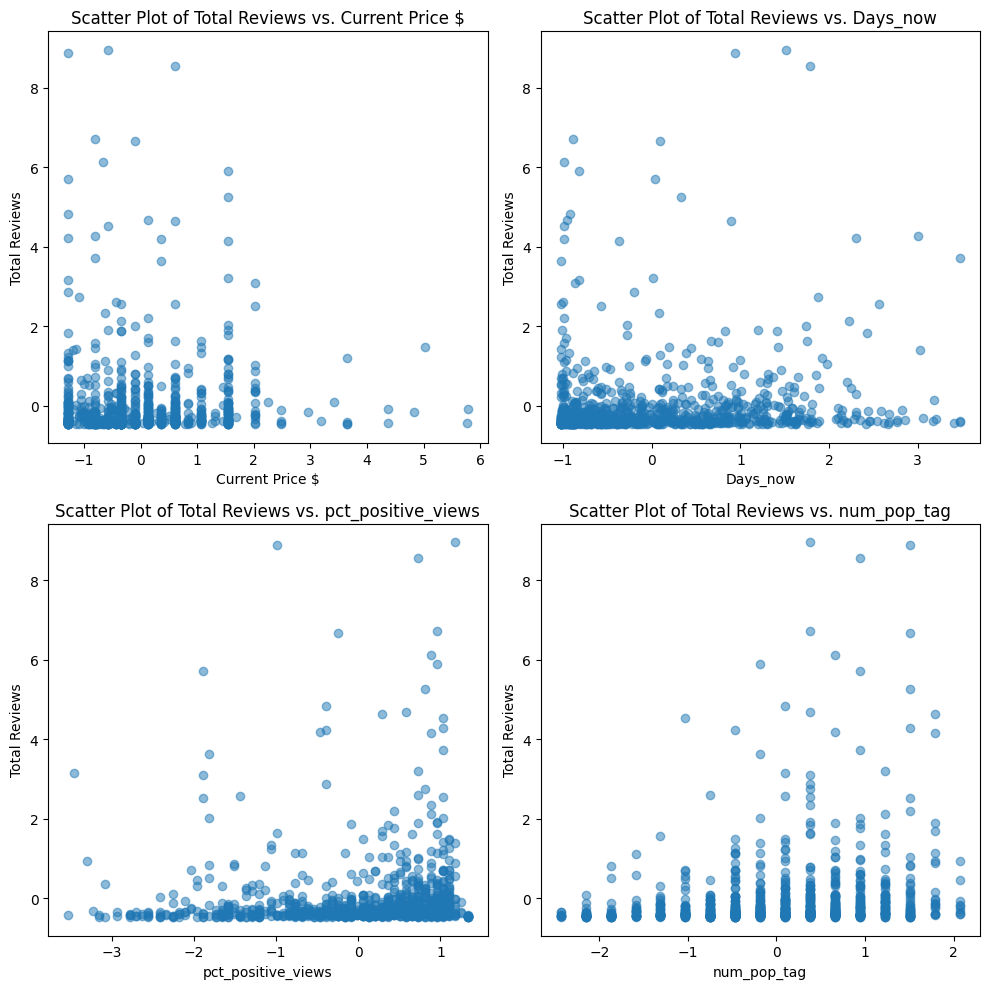

In [ ]:
# Create a 2x2 grid of scatterplots
# to see if there is relationship between features we select
fig, axs = plt.subplots(2,2, figsize=(10,10))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Loop through each feature in the list and create a scatter plot
for i, feature in enumerate(features):
    x = cleaned_data[feature]
    y = cleaned_data['total_reviews']

    # Create the scatter plot for the current feature in the corresponding subplot
    axs[i].scatter(x, y, alpha=0.5)

    # Add labels and title for clarity
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Total Reviews')
    axs[i].set_title(f'Scatter Plot of Total Reviews vs. {feature}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

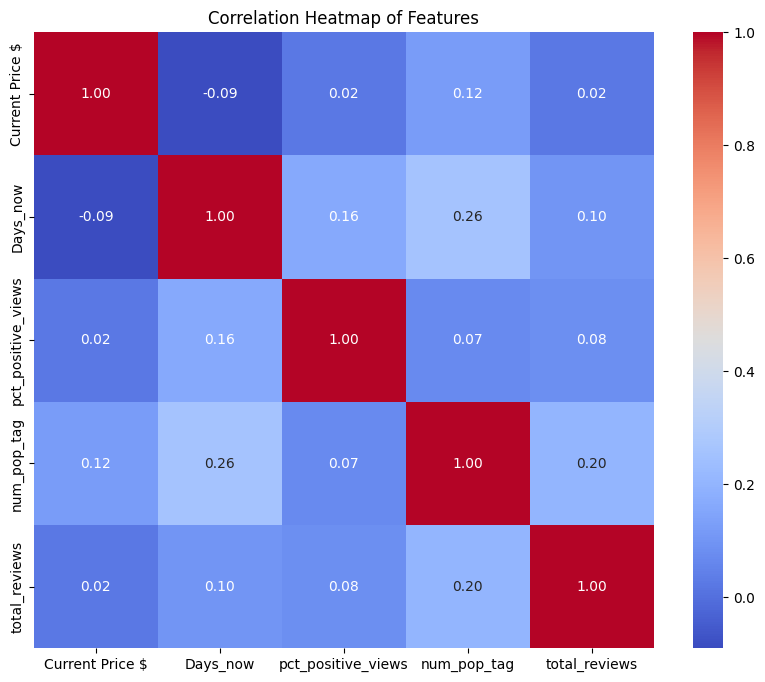

In [ ]:
# Calculate the correlation matrix for the DataFrame
correlation_matrix = cleaned_data[columns_to_scale].corr()

# Plot the heatmap of the correlation matrix using the coolwarm color map for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

Upon examining the scatter plot and correlation heatmap, it's evident that there's a lack of strong statistical evidence to assert that the four chosen features significantly influence the total views over the last 30 days. Among these, the feature with the highest correlation to the dependent variable is the "total number of popular tags."

## Step 3: Multiple Linear Regression for 4 features

In [ ]:
# get all the useful data from the data-frame
df = cleaned_data[columns_to_scale]
df.head()

,Current Price $,Days_now,pct_positive_views,num_pop_tag,total_reviews
3,-0.904533,-1.025982,0.731193,0.099363,0.519228
4,1.542506,0.010226,0.731193,1.226704,3.208450
5,-1.280530,0.040224,-1.888414,0.944869,5.705365
6,-1.280530,0.939299,-0.990263,1.508539,8.883018
7,-0.339832,2.102355,-0.241804,0.944869,-0.060757


In [ ]:
# drop none value
df = df.dropna()
df

,Current Price $,Days_now,pct_positive_views,num_pop_tag,total_reviews
3,-0.904533,-1.025982,0.731193,0.099363,0.519228
4,1.542506,0.010226,0.731193,1.226704,3.208450
5,-1.280530,0.040224,-1.888414,0.944869,5.705365
6,-1.280530,0.939299,-0.990263,1.508539,8.883018
7,-0.339832,2.102355,-0.241804,0.944869,-0.060757
...,...,...,...,...,...
995,0.601337,-0.831425,-1.514184,0.663034,-0.249997
996,5.772120,-0.504878,0.880885,0.381198,-0.432228
997,0.601337,0.596468,1.105423,-0.182472,-0.433104
998,-0.339832,1.143284,0.955731,0.099363,-0.190859


In [ ]:
# split X & y
X = df.iloc[:,:-1].values
y = df.iloc[:,4].values

In [ ]:
# check if there is still any missing value
missing_values = df.isna().sum()
missing_values

Current Price $       0
Days_now              0
pct_positive_views    0
num_pop_tag           0
total_reviews         0
dtype: int64

In [ ]:
# split up data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                               random_state=10)
X_train.shape

(735, 4)

In [ ]:
# create the model, fit the training set
regressor = LinearRegression()
regressor.fit(X = X_train, y = y_train)

LinearRegression()

In [ ]:
# predict the labels for our testing set
y_pred = regressor.predict(X_test)
y_pred = y_pred.tolist()

In [ ]:
def evaluate_regression_model(regressor, X_train, y_train, X_test, y_test):
    """
    Evaluate a regression model and print various evaluation metrics.
    """
    # Calculate mean squared error
    mse = mean_squared_error(y_test, regressor.predict(X_test))
    print("Mean squared error:", mse)

    # Get the coefficients of the linear regression model
    coefficients = regressor.coef_
    print("Coefficients:", coefficients)

    # Intercept
    print("Intercept:", regressor.intercept_)

    # R-squared on the training set
    r_squared_train = regressor.score(X_train, y_train)
    print("R-squared on the training set:", r_squared_train)

    # R-squared on the test set
    r_squared_test = regressor.score(X_test, y_test)
    print("R-squared on the test set:", r_squared_test)


In [ ]:
# Evaluate the regression model using the evaluate_regression_model function
evaluate_regression_model(regressor,X_train, y_train, X_test, y_test)

Mean squared error: 0.5577341154215829
Coefficients: [-0.02374678  0.04947003  0.0736575   0.18868594]
Intercept: 0.021400499243540042
R-squared on the training set: 0.04579726135347828
R-squared on the test set: 0.016193971936149687


Based on our output, we get the following information:
R-squared is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model. The R-squared for training set is 4.6%, which means that the model explains about 4.6% of the variance in the dependent variable based on the training data. This underperformance is further illustrated by the residual plot, where most of our dependent variables' residuals fall within the range of -1 to 4, though some residuals is close to 4. This pattern suggests that there are instances where the predictions significantly deviate from the actual values.
When this R-squared value drops even further to 1.5% on the testing set, it indicates an even weaker ability to predict or explain the variance in new, unseen data.









In [ ]:
def plot_residuals(y_pred, residuals, title='Residual Plot'):
    """
    Plots the residuals against the predicted values with a customizable title.

    Parameters:
    - y_pred: Predicted values
    - residuals: Residuals (difference between observed and predicted values)
    - title: Title of the plot (default is 'Residual Plot')
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')  # Add horizontal line at y=0 for reference
    plt.title(title)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

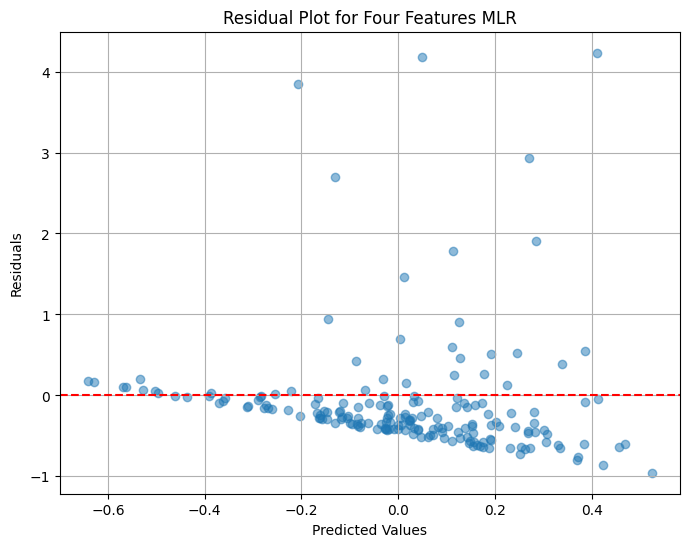

In [ ]:
residuals = y_test - y_pred

# Plot residuals against predicted values
plot_residuals(y_pred, residuals, 'Residual Plot for Four Features MLR')

## Step 4: 2nd Multiple Linear Regression for Tags

We transitioned to another Multiple Linear Regression model, and only use the 'tag' feature, which demonstrated the highest correlation with the total number of views among the four features we initially selected.

In [ ]:
# get the tag data from the original data-frame
tag_data = cleaned_data[['total_reviews', 'Tags']]
tag_data.head()

,total_reviews,Tags
3,0.519228,"Online Co-Op,Horror,First-Person,Multiplayer,P..."
4,3.208450,"Cyberpunk,Open World,Nudity,RPG,Singleplayer,S..."
5,5.705365,"Free to Play,Battle Royale,Multiplayer,FPS,Sho..."
6,8.883018,"Survival,Shooter,Battle Royale,Multiplayer,FPS..."
7,-0.060757,"RPG,MMORPG,Open World,Adventure,Fantasy,Explor..."


In [ ]:
# Update the dataframe based on the presence of each tag
for index, row in tag_data.iterrows():
    # Split the tags in the current row
    tags_list = row['Tags'].split(',')
    # Iterate through each popular tag
    for tag in pop_tags:
        if tag in tags_list:
             # If the tag is present, set the corresponding column to 1
            tag_data.at[index, tag] = 1
        else:
             # If the tag is present, set the corresponding column to 0
            tag_data.at[index, tag] = 0

<ipython-input-84-9d2a2af4a602>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_data.at[index, tag] = 0
<ipython-input-84-9d2a2af4a602>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_data.at[index, tag] = 0
<ipython-input-84-9d2a2af4a602>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [ ]:
tag_data.dropna(inplace=True)
tag_data.head()

,total_reviews,Tags,Singleplayer,Action,Multiplayer,Adventure,Simulation,Strategy,Open World,Co-op,...,FPS,Management,2D,Violent,Tactical,Gore,Horror,Free to Play,Difficult,Massively Multiplayer
3,0.519228,"Online Co-Op,Horror,First-Person,Multiplayer,P...",0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.208450,"Cyberpunk,Open World,Nudity,RPG,Singleplayer,S...",1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.705365,"Free to Play,Battle Royale,Multiplayer,FPS,Sho...",0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,8.883018,"Survival,Shooter,Battle Royale,Multiplayer,FPS...",0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,-0.060757,"RPG,MMORPG,Open World,Adventure,Fantasy,Explor...",1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X = tag_data.drop(['total_reviews','Tags'], axis=1)
y = tag_data['total_reviews']

In [ ]:
# split up data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                random_state=10)
X_train.shape

(735, 40)

In [ ]:
# create the model, fit the training set
regressor = LinearRegression()
regressor.fit(X = X_train, y = y_train)

y_pred = regressor.predict(X_test)

In [ ]:
# Evaluate the regression model using the evaluate_regression_model function
evaluate_regression_model(regressor,X_train, y_train, X_test, y_test)

Mean squared error: 0.5440589377307491
Coefficients: [-0.13012402  0.11234875  0.20631507  0.02671938 -0.0810241  -0.13255529
  0.04201969 -0.03572829 -0.02864851  0.07586628  0.05085659  0.2511061
 -0.10904132  0.15071518  0.04742533  0.0195797  -0.1145528   0.14394893
  0.21353238 -0.06632038 -0.05649718  0.11722985  0.18917151  0.28364183
  0.2424643  -0.04661795  0.08716906 -0.00732948  0.1218663  -0.0509354
  0.06012478 -0.09779051  0.27268442 -0.04125346  0.08131057 -0.07997136
  0.0722397   0.20345735  0.08303397 -0.55420696]
Intercept: -0.31396091477563853
R-squared on the training set: 0.11873197318266393
R-squared on the test set: 0.04031607936168724


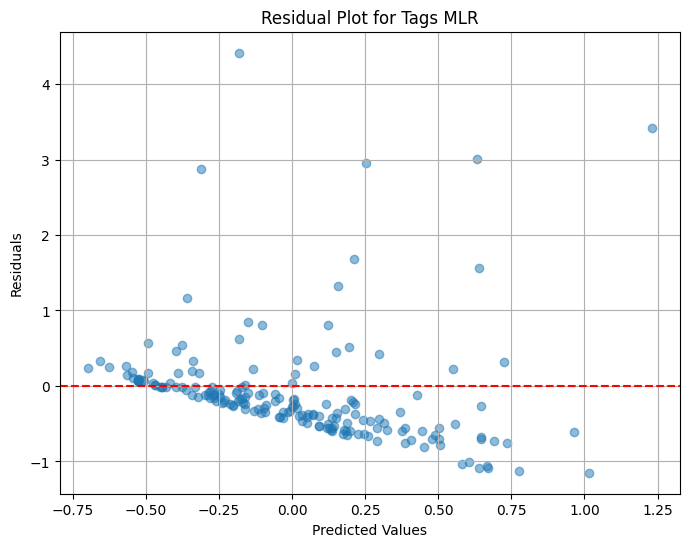

In [ ]:
residuals = y_test - y_pred

# Plot residuals against predicted values
plot_residuals(y_pred, residuals, 'Residual Plot for Tags MLR')

The R-squared is 0.119 in this model, these R-squared values point that this model has some predictive capability but is far from capturing the full complexity for all the influential factors of the dependent variable.


## Step 5: OLS model for Tags

We aim to delve deeper into the relationship between the tags, specifically to identify which features significantly impact the outcome. Therefore, we have decided to employ an Ordinary Least Squares (OLS) model for this analysis.

In [ ]:
# show the names of the features
feature_names = list(X.columns)
print(feature_names)

['Singleplayer', 'Action', 'Multiplayer', 'Adventure', 'Simulation', 'Strategy', 'Open World', 'Co-op', 'Atmospheric', 'RPG', 'Indie', 'First-Person', 'Story Rich', 'Sandbox', 'Online Co-Op', 'Casual', 'Exploration', 'PvP', 'Third Person', '3D', 'Realistic', 'Survival', 'Character Customization', 'Great Soundtrack', 'Early Access', 'Fantasy', 'Shooter', 'Funny', 'Building', 'Sci-fi', 'FPS', 'Management', '2D', 'Violent', 'Tactical', 'Gore', 'Horror', 'Free to Play', 'Difficult', 'Massively Multiplayer']


In [ ]:
# Add a constant column to the feature matrix X_train
X_train = sm.add_constant(X_train)

In [ ]:
# Create an Ordinary Least Squares (OLS) model using the training data
model = sm.OLS(y_train, X_train.astype(float))

In [ ]:
# Print the summary of the regression results, including the names of the features
results = model.fit()
results.summary(xname=['intercept'] + feature_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          total_reviews   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     2.338
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           9.99e-06
Time:                        19:33:33   Log-Likelihood:                -1033.4
No. Observations:                 735   AIC:                             2149.
Df Residuals:                     694   BIC:                             2337.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                  -0.3140      0.144     -2.175      0.030      -0.597      -0.031
Singleplayer               -0.1301      0.093     -1.404      0.161      -0.312       0.052
Action                      0.1123      0.100      1.124      0.261      -0.084       0.309
Multiplayer                 0.2063      0.105      1.966      0.050       0.000       0.412
Adventure                   0.0267      0.097      0.275      0.783      -0.164       0.217
Simulation                 -0.0810      0.114     -0.713      0.476      -0.304       0.142
Strategy                   -0.1326      0.099     -1.341      0.180      -0.327       0.062
Open World                  0.0420      0.101      0.414      0.679      -0.157       0.241
Co-op                      -0.0357      0.110     -0.324      0.746      -0.252       0.181
Atmospheric                -0.0286      0.096     -0.297      0.767      -0.218       0.161
RPG                         0.0759      0.107      0.708      0.479      -0.135       0.286
Indie                       0.0509      0.094      0.544      0.587      -0.133       0.234
First-Person                0.2511      0.116      2.167      0.031       0.024       0.479
Story Rich                 -0.1090      0.108     -1.006      0.315      -0.322       0.104
Sandbox                     0.1507      0.115      1.305      0.192      -0.076       0.377
Online Co-Op                0.0474      0.111      0.427      0.670      -0.171       0.266
Casual                      0.0196      0.105      0.187      0.852      -0.186       0.225
Exploration                -0.1146      0.110     -1.040      0.299      -0.331       0.102
PvP                         0.1439      0.124      1.162      0.246      -0.099       0.387
Third Person                0.2135      0.110      1.943      0.052      -0.002       0.429
3D                         -0.0663      0.105     -0.634      0.526      -0.272       0.139
Realistic                  -0.0565      0.118     -0.478      0.633      -0.289       0.176
Survival                    0.1172      0.121      0.971      0.332      -0.120       0.354
Character Customization     0.1892      0.113      1.673      0.095      -0.033       0.411
Great Soundtrack            0.2836      0.116      2.455      0.014       0.057       0.510
Early Access                0.2425      0.112      2.158      0.031       0.022       0.463
Fantasy                    -0.0466      0.118     -0.394      0.694      -0.279       0.186
Shooter                     0.0872      0.159      0.547      0.584      -0.226       0.400
Funny                      -0.0073      0.114     -0.064      0.949      -0.230       0.216
Building                    0.1219      0.140      0.869      0.385      -0.154       0.397
Sci-fi                     -0.0509      0.121  

The R-squared from the OLS is similar to the multilinear regression's R-squared, because both of them are regression model. In the OLS output, significant variables are identified by their p-values (P>|t|). Typically, a variable is considered significant if its p-value is less than a chosen significance level (which is 0.05 in this model). The significant variables are: Multiplayer, Great Soundtrack, 2D, Massively Multiplayer... Other variables, despite having some level of association with the dependent variable, are not statistically significant at the common 0.05 threshold, as their p-values are higher.